In [42]:
import os
import kornia as K
import kornia.feature as KF
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

In [43]:
current_dir=os.getcwd()
# specify the image directories
pkg_path='\\files'
pkg_path = os.path.join(os.path.realpath(current_dir+pkg_path))
# adding all files to the list
file_list=[i for i in os.listdir(pkg_path)]

In [44]:
# load images function (from image to tensor)
def load_image(pack_image,fname,new_size:tuple):
    img=cv2.imread(pack_image+'\\'+fname).astype(np.float32)
    resize_img=cv2.resize(img,new_size)
    return resize_img

def preprocess_image(img):
    # print(f"Input image type: {type(img)}")
    # print(f"Input image shape: {img.shape if hasattr(img, 'shape') else 'No shape attribute'}")
    
    # Convert numpy array to Tensor and ensure correct shape
    if isinstance(img, np.ndarray):
        img = K.image_to_tensor(img, keepdim=False).float() / 255.0
    elif isinstance(img, torch.Tensor):
        img = img.float()
        if img.max() > 1.0:
            img = img / 255.0
    else:
        raise ValueError(f"Unsupported image type: {type(img)}")
    
    # print(f"After conversion to tensor - shape: {img.shape}")
    
    # Ensure 4D tensor (B, C, H, W)
    if img.ndim == 2:
        img = img.unsqueeze(0).unsqueeze(0)
    elif img.ndim == 3:
        if img.shape[0] in [1, 3]:
            img = img.unsqueeze(0)
        else:
            img = img.unsqueeze(1)
    elif img.ndim == 4:
        if img.shape[1] not in [1, 3]:
            img = img.permute(0, 3, 1, 2)
    
    # print(f"After ensuring 4D - shape: {img.shape}")
    
    # Ensure 3 channel image
    if img.shape[1] == 1:
        img = img.repeat(1, 3, 1, 1)
    elif img.shape[1] > 3:
        img = img[:, :3]  # Take only the first 3 channels if more than 3
    
    # print(f"Final tensor shape: {img.shape}")
    return img

# make list of img tensors
def tensor_pkg(pkg_path,file_list,new_size:tuple):
    return [preprocess_image(load_image(pkg_path,file_list[i],new_size)) for i in range(len(file_list))]



In [45]:
tensor_pack=tensor_pkg(pkg_path,file_list,(500,500))

In [46]:
from kornia.contrib import ImageStitcher

IS = ImageStitcher(KF.LoFTR(pretrained="outdoor"), estimator="ransac")
# l=[img_1,img_2]
with torch.no_grad():
    out = IS(*tensor_pack)

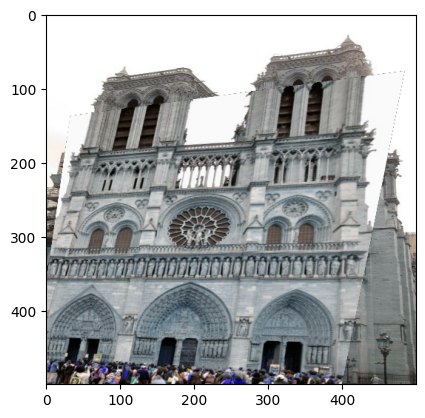

In [47]:
plt.imshow(K.tensor_to_image(out))
plt.show()